In [1]:
#cnn
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
import os

EPOCH=1
BATCH_SIZE=50
LR=0.001
DOWNLOAD_MNIST=False

if not(os.path.exists('./mnist'))or not os.listdir('./mnist'):
    #不存在minist或者mnist是空的
    DOWNLOAD_MNIST=True

train_data=torchvision.datasets.MNIST(
    root='./mnist',
    train=True,#表示trainning data,6w个
    transform=torchvision.transforms.ToTensor(),#转换为tensor，并且像素点正则化到(0，1)
    download=DOWNLOAD_MNIST
    )
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

train_loader=Data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True)
#每个mini-batch，image batch的shape为（50，1，28，28）

test_data=torchvision.datasets.MNIST(root='./mnist',train=False)
test_x=Variable(torch.unsqueeze(test_data.test_data,dim=1).type(torch.FloatTensor),volatile=True)[:2000]/255
 # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y=test_data.test_labels[:2000]
print(test_y[:12])

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1=nn.Sequential(
            nn.Conv2d(
                in_channels=1,#（1，28，28）
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2 #padding=(kernel_size-1)/2 if stride=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)#（16，14，14）
        )
        self.conv2=nn.Sequential(
            nn.Conv2d(16,32,5,1,2),
            nn.ReLU(),
            nn.MaxPool2d(2)#（32，7，7）
        )
        self.out=nn.Linear(32*7*7,10)#全连接层, 10个分类
        
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)#（batch,32，7，7)
        x=x.view(x.size(0),-1)#size(0)保留batch,-1改编为32*7*7 #（batch,32*7*7)
        output=self.out(x)#32*7*7的输入，10的输出
        return output #x为了可视化，否则只output即可

cnn=CNN()
print(cnn)
print(cnn(test_x))
print(cnn(test_x).size())

optimizer=torch.optim.Adam(cnn.parameters(),lr=LR)
loss_func=nn.CrossEntropyLoss()



for epoch in range(EPOCH):
    for step ,(b_x,b_y)in enumerate(train_loader):
        b_x,b_y=Variable(b_x),Variable(b_y)
        output=cnn(b_x)
        loss=loss_func(output,b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step%50==0:#每50步打印一次
            test_output=cnn(test_x)
            pred_y=torch.max(test_output,1)[1].data.numpy()
            accuracy=float((pred_y==test_y.data.numpy()).astype(int).sum())/float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
           

        
test_output= cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy()
print(pred_y, 'prediction number')
print(test_y[:10].numpy(), 'real number')


D:\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 28, 28])


D:\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([60000])


<Figure size 640x480 with 1 Axes>

D:\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
D:\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6])
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
tensor([[-0.0255,  0.0030,  0.0590,  ...,  0.0234,  0.0286,  0.0582],
        [-0.0628,  0.0044,  0.0469,  ...,  0.0370, -0.0209,  0.0952],
        [-0.0164,  0.0382,  0.0344,  ..., -0.0002, -0.0194,  0.0656],
        ...,
        [-0.0407,  0.0054,  0.0520,  ...,  0.0483, -0.0229,  0.0954],
        [-0.0218, -0.0177,  0.0531,  ...,  0.0153, -0.0047,  0.0657],
        [-0.0545, -0.0088,  0.0615,  ...,  0.0205, -0.0010,  0.0917]],
       grad_fn=<AddmmBackward>)
torch.Size([2000,

In [2]:
#RNN分类,LSTM
import torch
from torch import nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

EPOCH=1
BATCH_SIZE=64
TIME_STEP=28     #RNN time step/image height,从上到下一行行扫像素点
INPUT_SIZE=28    #RNN input size/image width
LR=0.01
DOWNLOAD_MNIST=True

train_data=dsets.MNIST(root='./mnist',train=True,transform=transforms.ToTensor(),download=DOWNLOAD_MNIST)
train_loader=torch.utils.data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True,)

test_data=dsets.MNIST(root='./mnist',train=False,transform=transforms.ToTensor())
test_x=Variable(test_data.test_data,volatile=True).type(torch.FloatTensor)[:2000]/255
test_y=test_data.test_labels.numpy()[:2000]


class RNN(nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        
        self.rnn=nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=64,    #RNN hidden units
            num_layers=1,       #RNN layer
            batch_first=True  #input,output会带上batch作为第一维度 (batch, time_step, input_size)            
        )
        
        self.out=nn.Linear(64,10)
        
    def forward(self,x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size/hidden_size)
        # h_n，h_c shape (n_layers, batch, hidden_size)为长短期记忆的分线和主线的hidden state
       
        r_out,(h_n,h_c)=self.rnn(x,None)#none代表没有初始的hidden state
        out=self.out(r_out[:,-1,:])#要最后一个time step的输出
        return out

rnn=RNN()
print(test_x.size())
print(rnn(test_x[:2]))


optimizer=torch.optim.Adam(rnn.parameters(),lr=LR)
loss_func=nn.CrossEntropyLoss()

for epoch in range(EPOCH):
    for step,(b_x,b_y)in enumerate(train_loader):
        b_x=Variable(b_x.view(-1,28,28))#(64,1,28,28)-->(64,28,28)前面乘一起
        b_y=Variable(b_y)
        output=rnn(b_x)
        loss=loss_func(output,b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y).astype(int).sum()) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)


test_output = rnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy()
print(pred_y, 'prediction number')
print(test_y[:10], 'real number')

D:\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
D:\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


torch.Size([2000, 28, 28])
tensor([[-0.0432,  0.0364,  0.0456, -0.1059, -0.0458, -0.0460,  0.0566, -0.0439,
         -0.1216, -0.0050],
        [-0.0540,  0.0433,  0.0266, -0.1122, -0.0573, -0.0462,  0.0409, -0.0371,
         -0.1179,  0.0159]], grad_fn=<AddmmBackward>)
Epoch:  0 | train loss: 2.3065 | test accuracy: 0.19
Epoch:  0 | train loss: 1.0349 | test accuracy: 0.61
Epoch:  0 | train loss: 0.6527 | test accuracy: 0.72
Epoch:  0 | train loss: 0.5251 | test accuracy: 0.80
Epoch:  0 | train loss: 0.4647 | test accuracy: 0.86
Epoch:  0 | train loss: 0.3564 | test accuracy: 0.89
Epoch:  0 | train loss: 0.3493 | test accuracy: 0.90
Epoch:  0 | train loss: 0.4899 | test accuracy: 0.89
Epoch:  0 | train loss: 0.2496 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1814 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1872 | test accuracy: 0.92
Epoch:  0 | train loss: 0.4290 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1551 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1072 | test ac

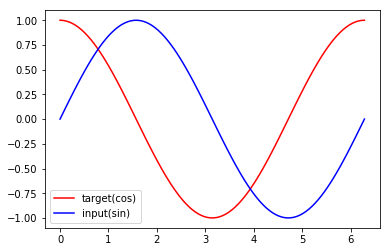

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


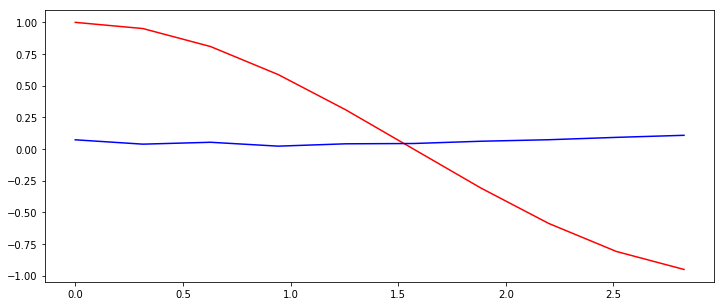

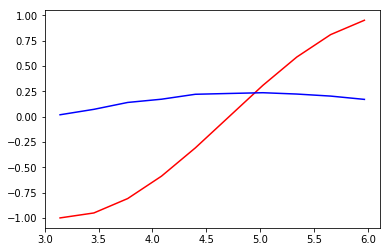

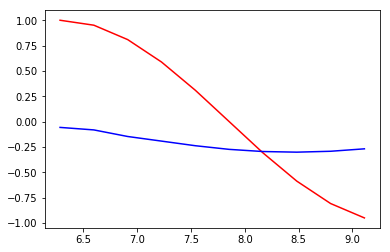

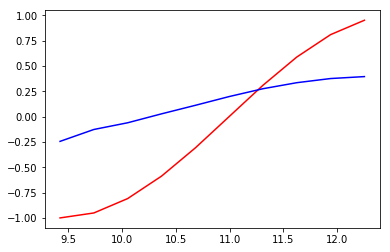

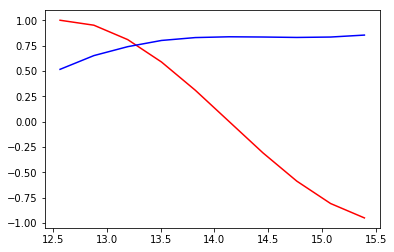

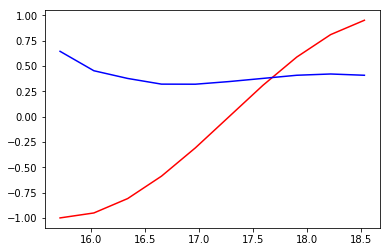

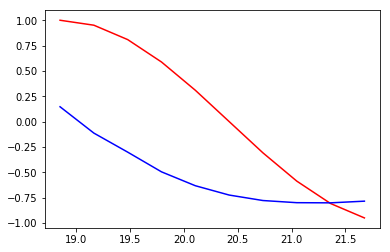

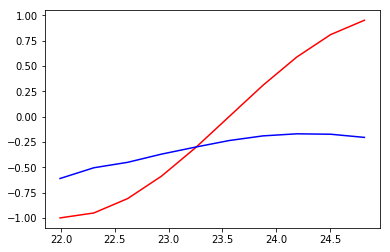

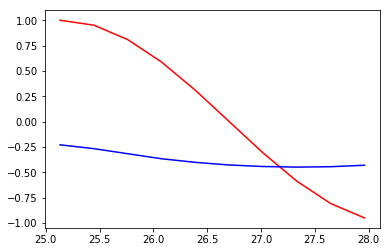

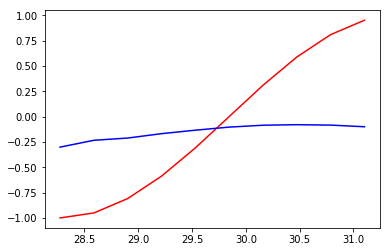

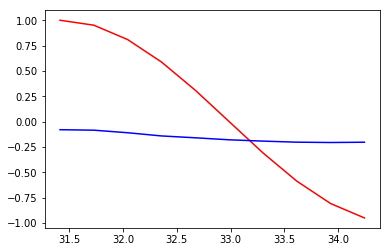

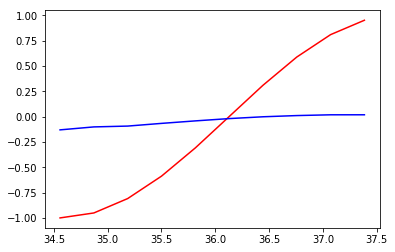

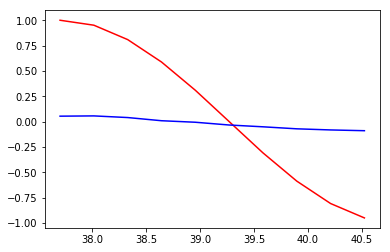

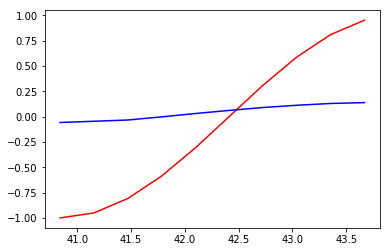

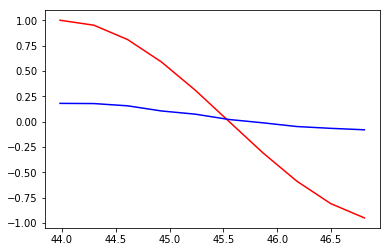

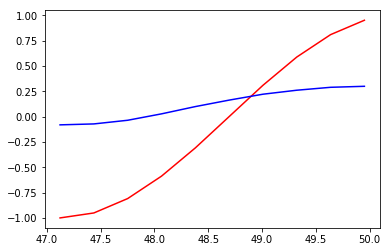

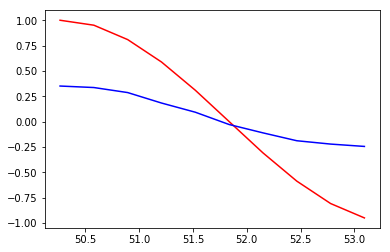

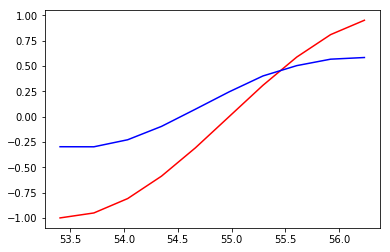

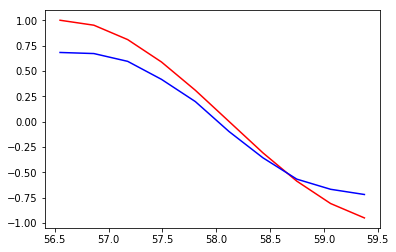

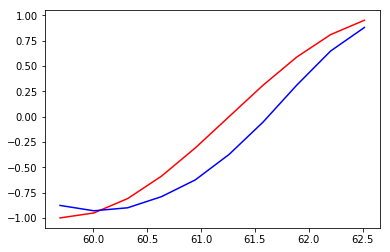

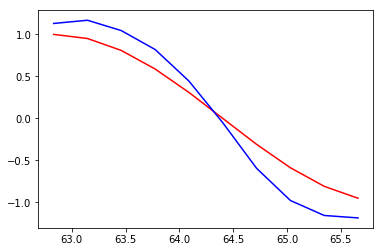

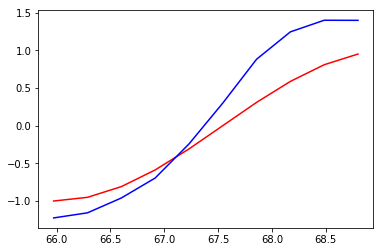

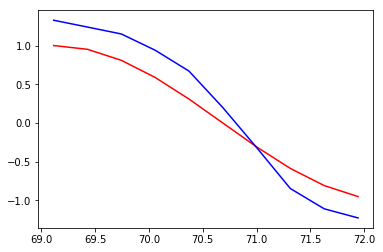

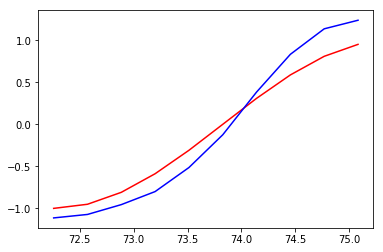

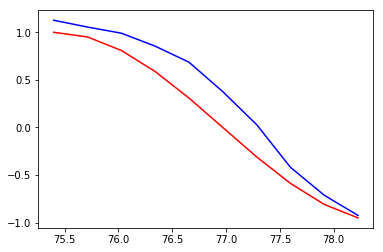

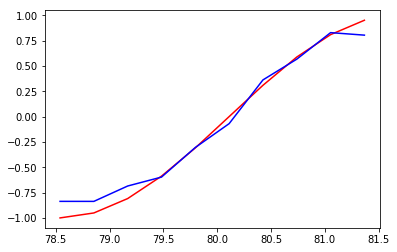

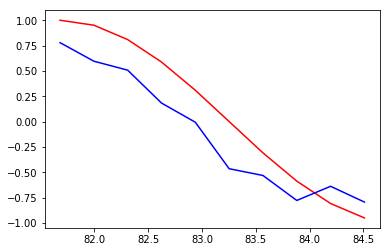

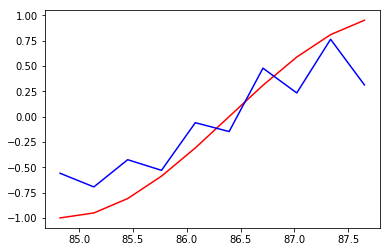

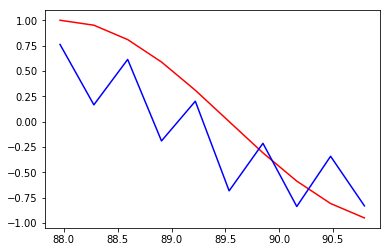

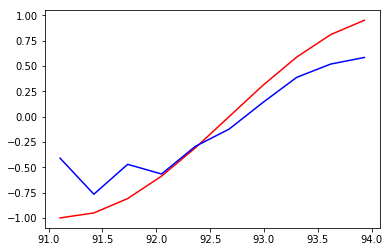

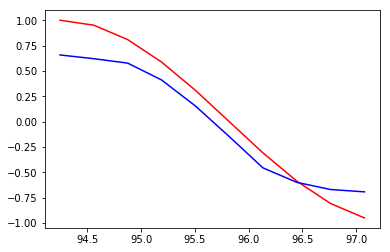

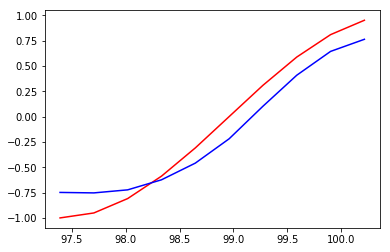

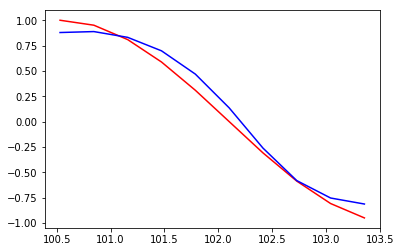

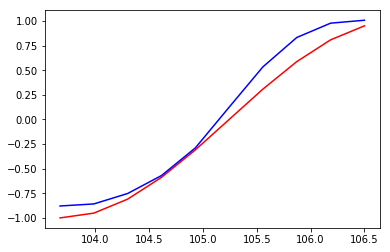

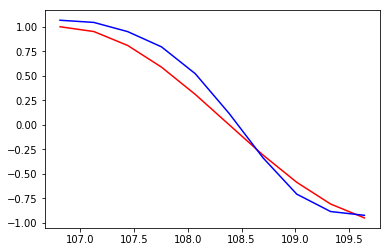

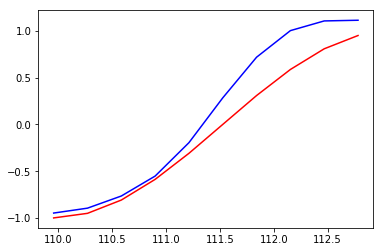

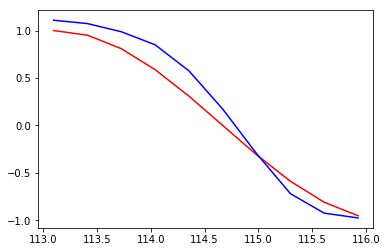

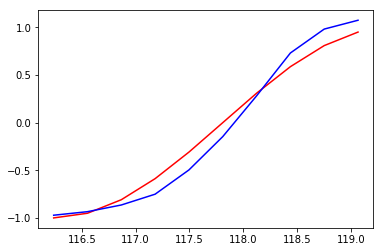

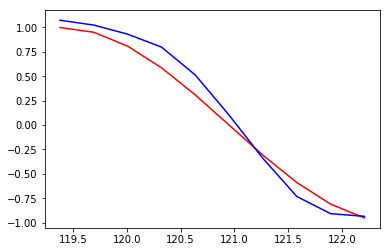

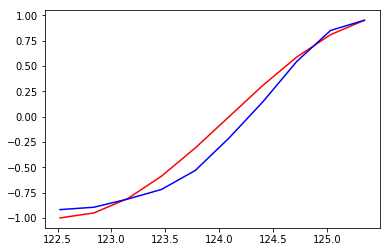

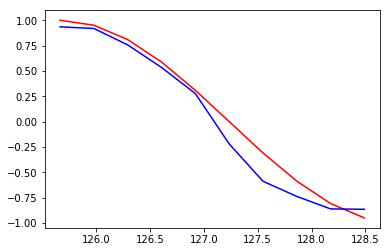

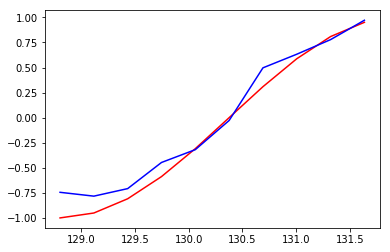

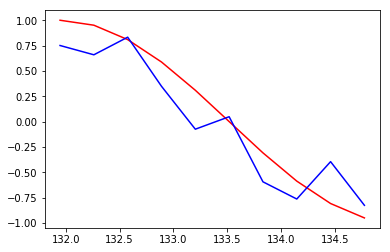

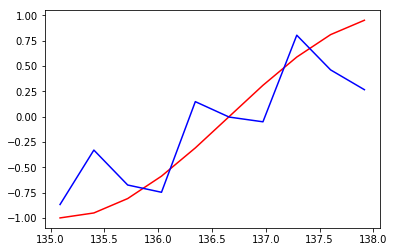

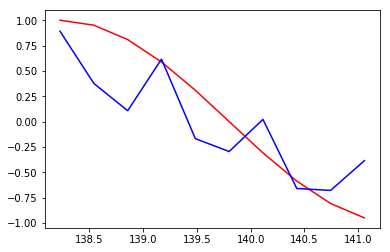

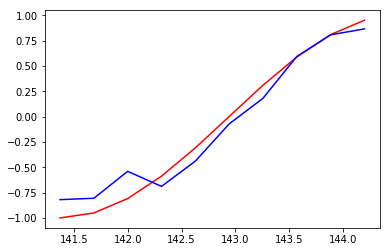

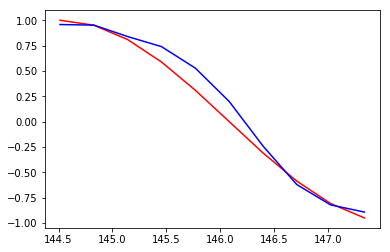

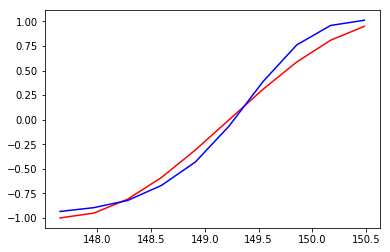

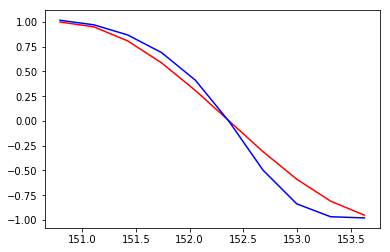

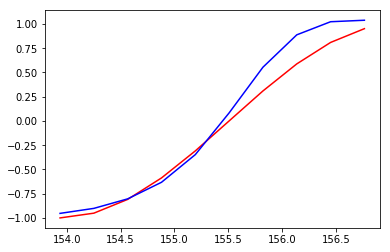

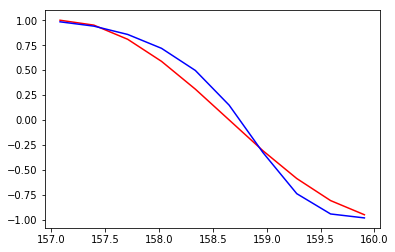

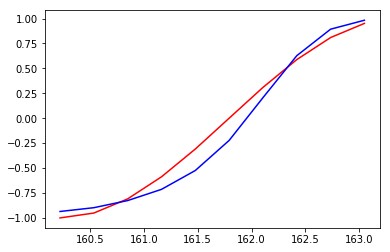

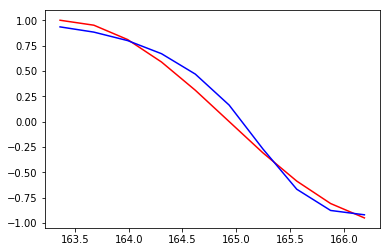

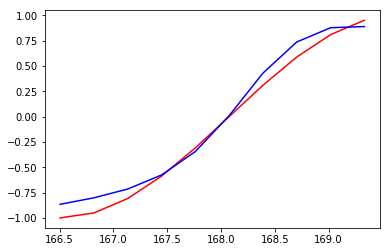

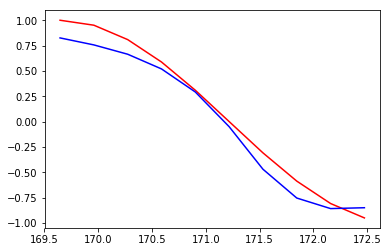

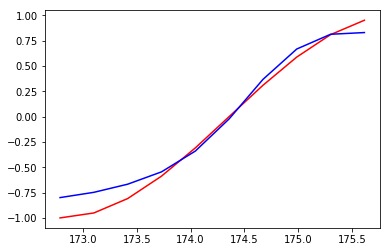

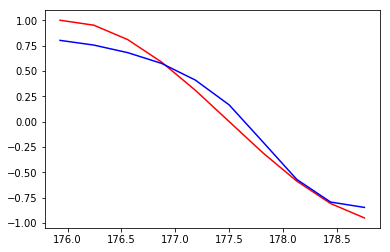

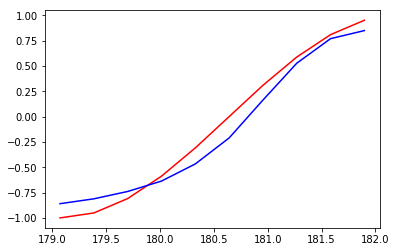

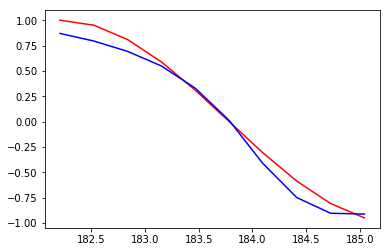

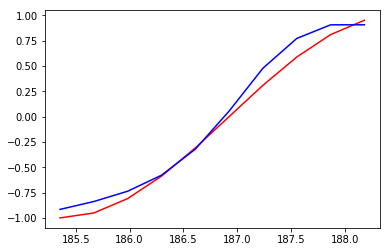

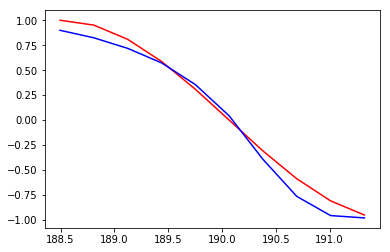

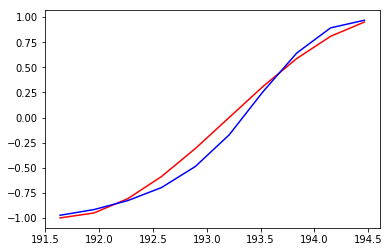

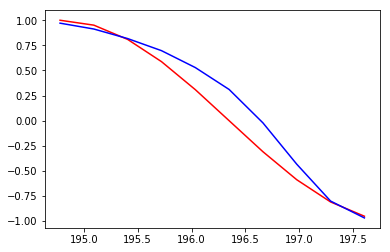

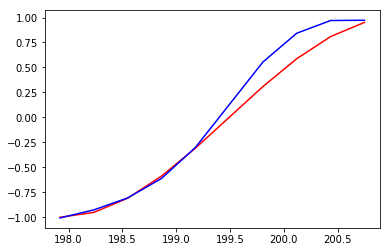

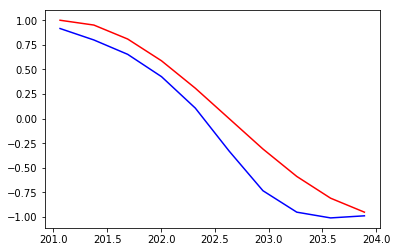

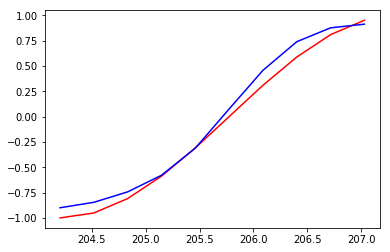

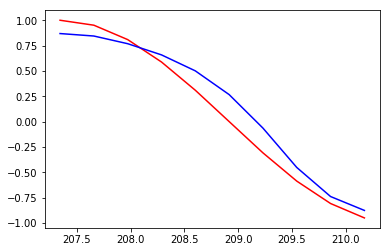

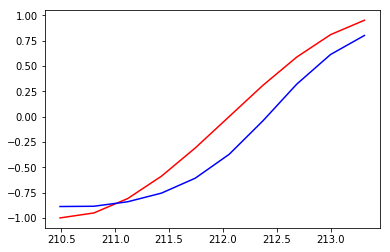

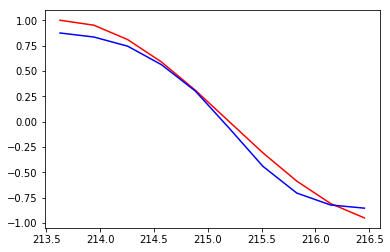

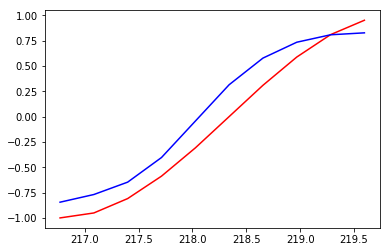

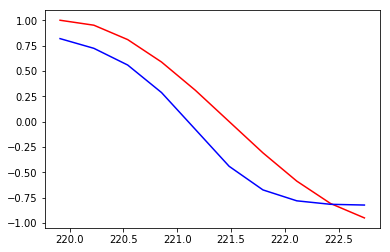

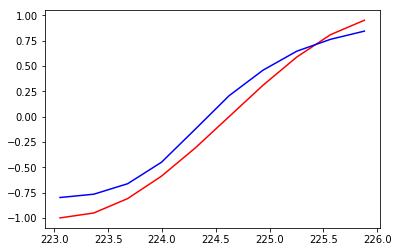

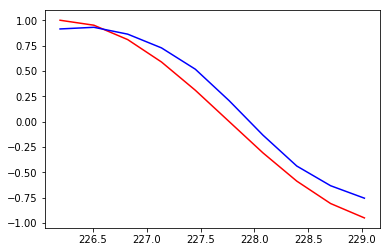

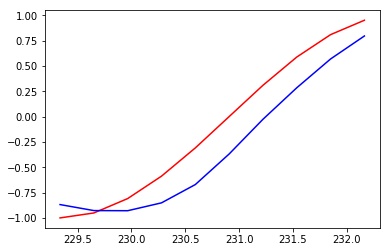

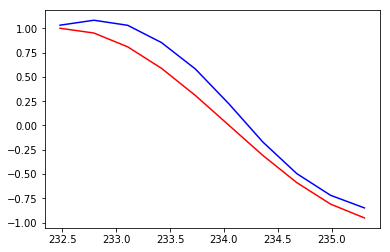

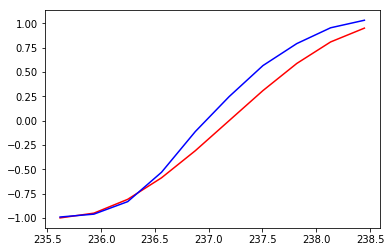

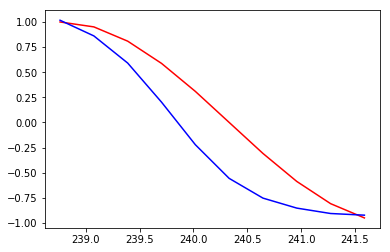

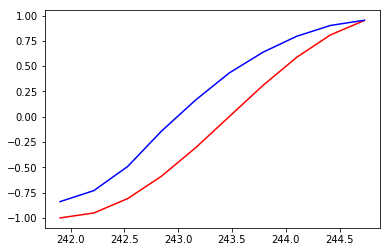

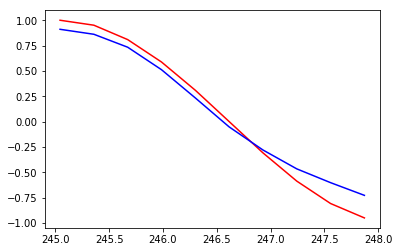

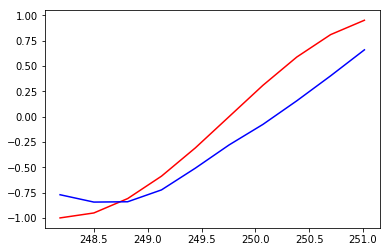

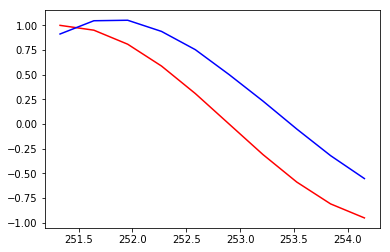

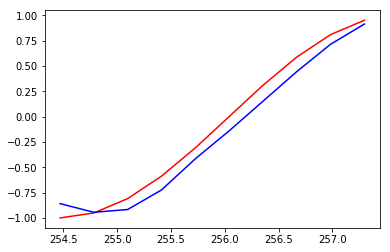

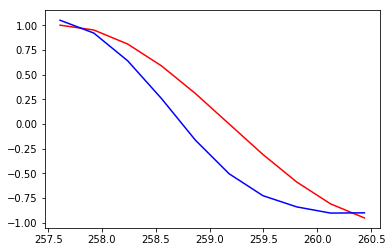

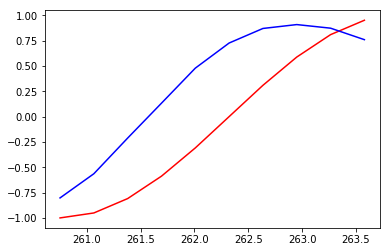

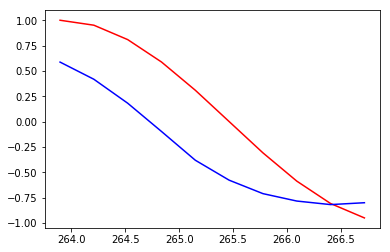

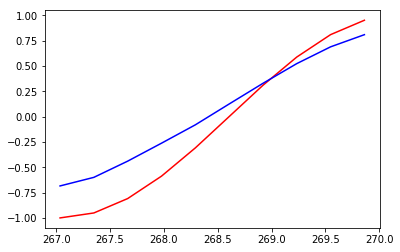

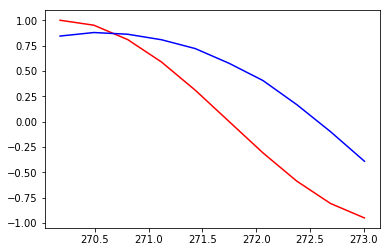

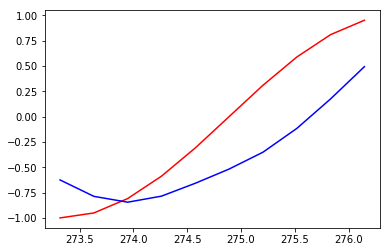

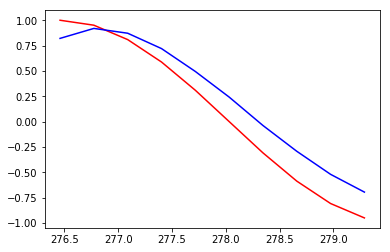

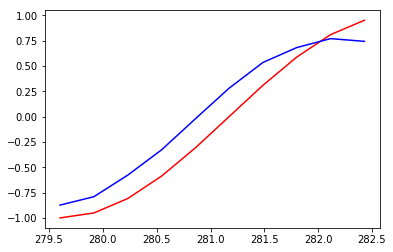

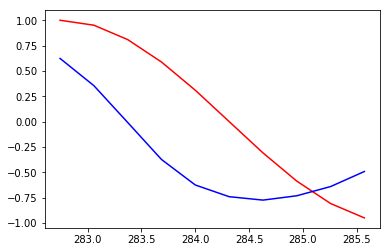

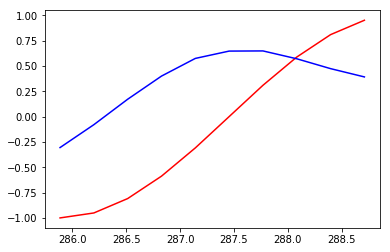

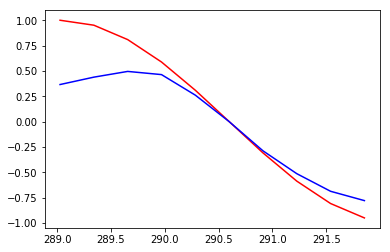

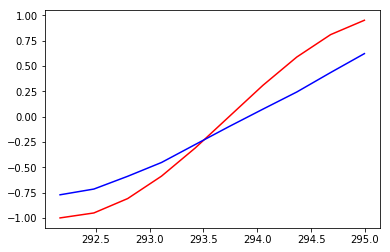

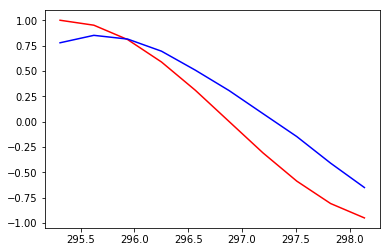

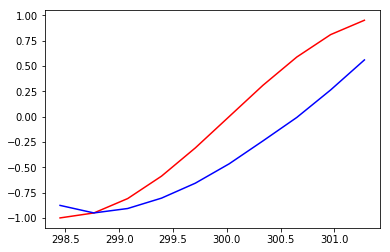

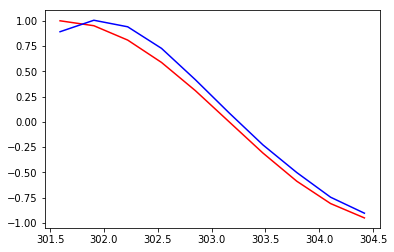

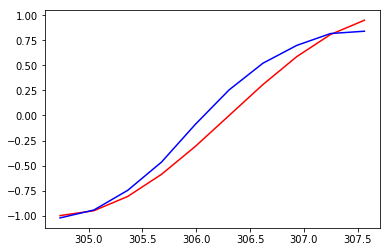

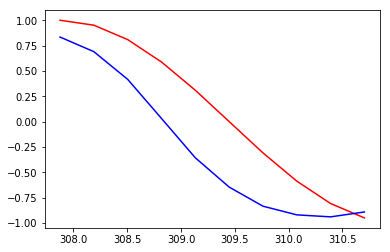

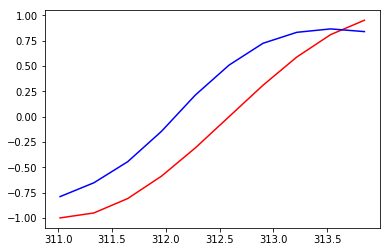

In [3]:
#RNN回归
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

TIME_STEP=10  #RNN time step
INPUT_SIZE=1  #RNN input size
LR=0.02

steps=np.linspace(0,np.pi*2,100,dtype=np.float32)
x_np=np.sin(steps)
y_np=np.cos(steps)
plt.plot(steps,y_np,'r-',label='target(cos)')
plt.plot(steps,x_np,'b-',label='input(sin)')
plt.legend(loc='best')
plt.show()

class RNN(nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        
        self.rnn=nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=32,
            num_layers=1,
            batch_first=True
        )
        self.out=nn.Linear(32,1)
        
    def forward(self,x,h_state):
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, hidden_size)
        r_out,h_state=self.rnn(x,h_state)
        
        outs=[]#保存所有的预测
        for time_step in range(r_out.size(1)):
            outs.append(self.out(r_out[:,time_step,:]))
        return torch.stack(outs,dim=1),h_state#把list转换为tensor,合并在一起，保留r_out
         # instead, for simplicity, you can replace above codes by follows
        # r_out = r_out.view(-1, 32)
        # outs = self.out(r_out)
        # outs = outs.view(-1, TIME_STEP, 1)
        # return outs, h_state
        
        # or even simpler, since nn.Linear can accept inputs of any dimension 
        # and returns outputs with same dimension except for the last
        # outs = self.out(r_out)
        # return outs

rnn=RNN()
print(rnn)

optimizer=torch.optim.Adam(rnn.parameters(),lr=LR)
loss_func=nn.MSELoss()

h_state=None #初始化

plt.figure(1, figsize=(12, 5))
plt.ion() 

for step in range(100):
    start,end=step*np.pi,(step+1)*np.pi
    steps=np.linspace(start,end,TIME_STEP,dtype=np.float32,endpoint=False)
    x_np=np.sin(steps)
    y_np=np.cos(steps)
    
    x=Variable(torch.from_numpy(x_np[np.newaxis,:,np.newaxis]))
    y=Variable(torch.from_numpy(y_np[np.newaxis,:,np.newaxis]))
    
    prediction,h_state=rnn(x,h_state)
    h_state=Variable(h_state)#!!important
    
    loss = loss_func(prediction, y)         # calculate loss
    optimizer.zero_grad()                   # clear gradients for this training step
    loss.backward()                         # backpropagation, compute gradients
    optimizer.step()                        # apply gradients

    # plotting
    plt.plot(steps, y_np.flatten(), 'r-')#flatten返回一维数组，横着展平
    plt.plot(steps, prediction.data.numpy().flatten(), 'b-')
    plt.draw(); plt.pause(0.05)

plt.ioff()
plt.show()
    

D:\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 28, 28])


D:\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([60000])


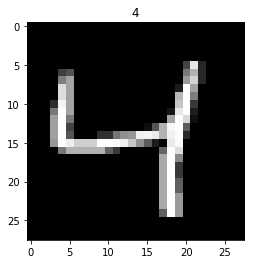

Epoch:  0 | train loss: 0.2326


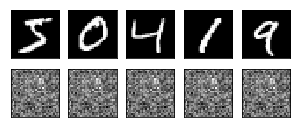

Epoch:  0 | train loss: 0.0692


<Figure size 432x288 with 0 Axes>

Epoch:  0 | train loss: 0.0675


<Figure size 432x288 with 0 Axes>

Epoch:  0 | train loss: 0.0659


<Figure size 432x288 with 0 Axes>

Epoch:  0 | train loss: 0.0625


<Figure size 432x288 with 0 Axes>

Epoch:  0 | train loss: 0.0578


<Figure size 432x288 with 0 Axes>

Epoch:  0 | train loss: 0.0577


<Figure size 432x288 with 0 Axes>

Epoch:  0 | train loss: 0.0578


<Figure size 432x288 with 0 Axes>

Epoch:  0 | train loss: 0.0536


<Figure size 432x288 with 0 Axes>

Epoch:  0 | train loss: 0.0512


<Figure size 432x288 with 0 Axes>

Epoch:  1 | train loss: 0.0545


<Figure size 432x288 with 0 Axes>

Epoch:  1 | train loss: 0.0509


<Figure size 432x288 with 0 Axes>

Epoch:  1 | train loss: 0.0502


<Figure size 432x288 with 0 Axes>

Epoch:  1 | train loss: 0.0488


<Figure size 432x288 with 0 Axes>

Epoch:  1 | train loss: 0.0515


<Figure size 432x288 with 0 Axes>

Epoch:  1 | train loss: 0.0489


<Figure size 432x288 with 0 Axes>

Epoch:  1 | train loss: 0.0458


<Figure size 432x288 with 0 Axes>

Epoch:  1 | train loss: 0.0463


<Figure size 432x288 with 0 Axes>

Epoch:  1 | train loss: 0.0466


<Figure size 432x288 with 0 Axes>

Epoch:  1 | train loss: 0.0415


<Figure size 432x288 with 0 Axes>

Epoch:  2 | train loss: 0.0491


<Figure size 432x288 with 0 Axes>

Epoch:  2 | train loss: 0.0449


<Figure size 432x288 with 0 Axes>

Epoch:  2 | train loss: 0.0490


<Figure size 432x288 with 0 Axes>

Epoch:  2 | train loss: 0.0439


<Figure size 432x288 with 0 Axes>

Epoch:  2 | train loss: 0.0437


<Figure size 432x288 with 0 Axes>

Epoch:  2 | train loss: 0.0420


<Figure size 432x288 with 0 Axes>

Epoch:  2 | train loss: 0.0409


<Figure size 432x288 with 0 Axes>

Epoch:  2 | train loss: 0.0405


<Figure size 432x288 with 0 Axes>

Epoch:  2 | train loss: 0.0417


<Figure size 432x288 with 0 Axes>

Epoch:  2 | train loss: 0.0453


<Figure size 432x288 with 0 Axes>

Epoch:  3 | train loss: 0.0392


<Figure size 432x288 with 0 Axes>

Epoch:  3 | train loss: 0.0413


<Figure size 432x288 with 0 Axes>

Epoch:  3 | train loss: 0.0411


<Figure size 432x288 with 0 Axes>

Epoch:  3 | train loss: 0.0409


<Figure size 432x288 with 0 Axes>

Epoch:  3 | train loss: 0.0382


<Figure size 432x288 with 0 Axes>

Epoch:  3 | train loss: 0.0418


<Figure size 432x288 with 0 Axes>

Epoch:  3 | train loss: 0.0426


<Figure size 432x288 with 0 Axes>

Epoch:  3 | train loss: 0.0402


<Figure size 432x288 with 0 Axes>

Epoch:  3 | train loss: 0.0464


<Figure size 432x288 with 0 Axes>

Epoch:  3 | train loss: 0.0449


<Figure size 432x288 with 0 Axes>

Epoch:  4 | train loss: 0.0389


<Figure size 432x288 with 0 Axes>

Epoch:  4 | train loss: 0.0405


<Figure size 432x288 with 0 Axes>

Epoch:  4 | train loss: 0.0401


<Figure size 432x288 with 0 Axes>

Epoch:  4 | train loss: 0.0399


<Figure size 432x288 with 0 Axes>

Epoch:  4 | train loss: 0.0367


<Figure size 432x288 with 0 Axes>

Epoch:  4 | train loss: 0.0344


<Figure size 432x288 with 0 Axes>

Epoch:  4 | train loss: 0.0370


<Figure size 432x288 with 0 Axes>

Epoch:  4 | train loss: 0.0378


<Figure size 432x288 with 0 Axes>

Epoch:  4 | train loss: 0.0419


<Figure size 432x288 with 0 Axes>

Epoch:  4 | train loss: 0.0391


<Figure size 432x288 with 0 Axes>

Epoch:  5 | train loss: 0.0409


<Figure size 432x288 with 0 Axes>

Epoch:  5 | train loss: 0.0354


<Figure size 432x288 with 0 Axes>

Epoch:  5 | train loss: 0.0390


<Figure size 432x288 with 0 Axes>

Epoch:  5 | train loss: 0.0366


<Figure size 432x288 with 0 Axes>

Epoch:  5 | train loss: 0.0384


<Figure size 432x288 with 0 Axes>

Epoch:  5 | train loss: 0.0362


<Figure size 432x288 with 0 Axes>

Epoch:  5 | train loss: 0.0367


<Figure size 432x288 with 0 Axes>

Epoch:  5 | train loss: 0.0365


<Figure size 432x288 with 0 Axes>

Epoch:  5 | train loss: 0.0386


<Figure size 432x288 with 0 Axes>

Epoch:  5 | train loss: 0.0372


<Figure size 432x288 with 0 Axes>

Epoch:  6 | train loss: 0.0343


<Figure size 432x288 with 0 Axes>

Epoch:  6 | train loss: 0.0404


<Figure size 432x288 with 0 Axes>

Epoch:  6 | train loss: 0.0367


<Figure size 432x288 with 0 Axes>

Epoch:  6 | train loss: 0.0426


<Figure size 432x288 with 0 Axes>

Epoch:  6 | train loss: 0.0411


<Figure size 432x288 with 0 Axes>

Epoch:  6 | train loss: 0.0325


<Figure size 432x288 with 0 Axes>

Epoch:  6 | train loss: 0.0387


<Figure size 432x288 with 0 Axes>

Epoch:  6 | train loss: 0.0362


<Figure size 432x288 with 0 Axes>

Epoch:  6 | train loss: 0.0416


<Figure size 432x288 with 0 Axes>

Epoch:  6 | train loss: 0.0341


<Figure size 432x288 with 0 Axes>

Epoch:  7 | train loss: 0.0374


<Figure size 432x288 with 0 Axes>

Epoch:  7 | train loss: 0.0349


<Figure size 432x288 with 0 Axes>

Epoch:  7 | train loss: 0.0364


<Figure size 432x288 with 0 Axes>

Epoch:  7 | train loss: 0.0350


<Figure size 432x288 with 0 Axes>

Epoch:  7 | train loss: 0.0342


<Figure size 432x288 with 0 Axes>

Epoch:  7 | train loss: 0.0354


<Figure size 432x288 with 0 Axes>

Epoch:  7 | train loss: 0.0367


In [ ]:
#Autocoder自编码 无监督学习
import torch 
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

EPOCH=10
BATCH_SIZE=64
LR=0.005
DOWNLOAD_MNIST=False
N_TEST_IMG=5

train_data=torchvision.datasets.MNIST(
    root='./mnist',train=True,transform=torchvision.transforms.ToTensor(),download=DOWNLOAD_MNIST
                                     )
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[2].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[2])
plt.show()

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        
        self.encoder=nn.Sequential(
            nn.Linear(28*28,128),
            nn.Tanh(),
            nn.Linear(128,64),
            nn.Tanh(),
            nn.Linear(64,12),
            nn.Tanh(),
            nn.Linear(12,3) #压缩为3个feature，相当于压缩到3维
        )
        self.decoder=nn.Sequential(
            nn.Linear(3,12),
            nn.Tanh(),
            nn.Linear(12,64),
            nn.Tanh(),
            nn.Linear(64,128),
            nn.Tanh(),
            nn.Linear(128,28*28),
            nn.Sigmoid()#上面loader里面的值都在0,1之间，所以用sigmoid改变值
        )
    def forward(self,x):
        encoded=self.encoder(x)
        decoded=self.decoder(encoded)
        return encoded,decoded

autoencoder=AutoEncoder()

optimizer=torch.optim.Adam(autoencoder.parameters(),lr=LR)
loss_func=nn.MSELoss()

# initialize figure
f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
plt.ion()   # continuously plot
# original data (first row) for viewing
view_data = train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.
for i in range(N_TEST_IMG):
    a[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())

for epoch in range(EPOCH):
    for step ,(x,b_label)in enumerate(train_loader):
        b_x=Variable(x.view(-1,28*28))
        b_y=Variable(x.view(-1,28*28))
        
        
        encoded,decoded=autoencoder(b_x)
        
        loss=loss_func(decoded,b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step%100==0:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy())

            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_data)
            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
            plt.draw(); plt.pause(0.05)

plt.ioff()
plt.show()



In [ ]:
#GAN
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

BATCH_SIZE=64
LR_G=0.0001             #generator生成器
LR_D=0.0001             #discriminater判别器
N_IDEAS=5               #think of this as number of ideas for generating an art work
ART_COMPONENTS=15       #相当于一张画的总点数（这些点组成一幅画）
PAINT_POINTS=np.vstack([np.linspace(-1,1,ART_COMPONENTS)for _ in range(BATCH_SIZE)])

plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
plt.legend(loc='upper right')
plt.show()

def artist_works():
    a=np.random.uniform(1,2,size=BATCH_SIZE)[:,np.newaxis]
    paintings=a*np.power(PAINT_POINTS,2)+(a-1)
    paintings=torch.from_numpy(paintings).float()
    return paintings

G=nn.Sequential(
    nn.Linear(N_IDEAS,128),
    nn.ReLU(),
    nn.Linear(128,ART_COMPONENTS)
)#用5个idead画一幅画

D=nn.Sequential(
    nn.Linear(ART_COMPONENTS,128),
    nn.ReLU(),
    nn.Linear(128,1),
    nn.Sigmoid()
)#输入一幅画，判断是好作品的概率

opt_D=torch.optim.Adam(D.parameters(),lr=LR_D)
opt_G=torch.optim.Adam(G.parameters(),lr=LR_G)

plt.ion()

for step in range(10000):
    artist_paintings=artist_works()
    G_ideas=torch.randn(BATCH_SIZE,N_IDEAS)#矩阵，NIDEAS列,表示random ideas
    G_paintings=G(G_ideas)
    
    prob_artist0=D(artist_paintings)#artist_paintings是好作品的概率
    prob_artist1=D(G_paintings)#G作品是好作品的概率
    
    D_loss=-torch.mean(torch.log(prob_artist0)+torch.log(1-prob_artist1))
    #增加0的概率，减小1的概率，使D判断更准
    G_loss=torch.mean(torch.log(1-prob_artist1))
    #增加1的概率，使G生成更好的作品
    
    opt_D.zero_grad()
    D_loss.backward(retain_graph=True)#保留参数给下一个反向传播
    opt_D.step()
    
    opt_G.zero_grad()
    G_loss.backward()
    opt_G.step()
    
    if step % 50 == 0:  # plotting
        plt.cla()
        plt.plot(PAINT_POINTS[0], G_paintings.data.numpy()[0], c='#4AD631', lw=3, label='Generated painting',)
        plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
        plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
        plt.text(-.5, 2.3, 'D accuracy=%.2f (0.5 for D to converge)' % prob_artist0.data.numpy().mean(), fontdict={'size': 13})
        plt.text(-.5, 2, 'D score= %.2f (-1.38 for G to converge)' % -D_loss.data.numpy(), fontdict={'size': 13})
        plt.ylim((0, 3));plt.legend(loc='upper right', fontsize=10);plt.draw();plt.pause(0.01)

plt.ioff()
plt.show()